In [29]:
%matplotlib inline

import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import math

## Set up display

In [31]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network

In [12]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height * img_width * 3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience class

In [16]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [18]:
e = Experience (2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [20]:
class ReplayMemory():
    def __init(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon greedy strategy

In [26]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

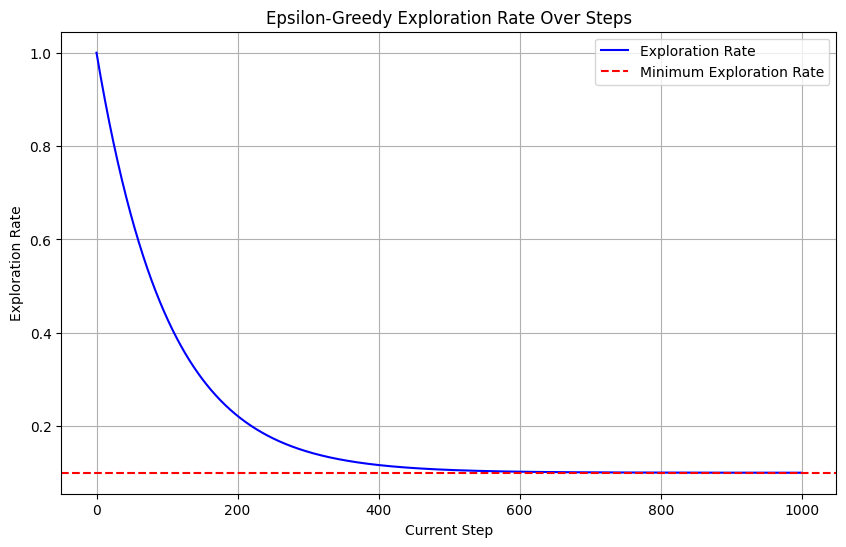

In [33]:
start = 1.0  # Starting exploration rate
end = 0.1    # Minimum exploration rate
decay = 0.01 # Decay rate

strategy = EpsilonGreedyStrategy(start, end, decay)

steps = range(0, 1000)  # Current steps from 0 to 999
exploration_rates = [strategy.get_exploration_rate(step) for step in steps]

plt.figure(figsize=(10, 6))
plt.plot(steps, exploration_rates, label='Exploration Rate', color='blue')
plt.title('Epsilon-Greedy Exploration Rate Over Steps')
plt.xlabel('Current Step')
plt.ylabel('Exploration Rate')
plt.axhline(y=end, color='red', linestyle='--', label='Minimum Exploration Rate')
plt.legend()
plt.grid()
plt.show()

## Reinforcement Learning Agent

In [35]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_network):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return random.randrange(self.num_actions) # explore
        else:
            with torch.no_grad(): # We only infer, not train
                return policy_network(state).argmax(dim=1).item() # exploit

## Main program

In [36]:
batch_size = 256
gamma = 0.999
eps_start =1
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # episodes
memory_size = 100000 # capacity of replay memory
lr = 0.001
num_episodes = 1000


In [37]:
print(torch.cuda.is_available())

False
